In [76]:
from skopt import gp_minimize
from skopt import forest_minimize # Bayesian Optimization with RF as surrogate
from skopt import gbrt_minimize # Bayesian Optimization with GBM as surrogate
from skopt import Optimizer # for the optimization
from joblib import Parallel, delayed # for the parallelization
from skopt import dummy_minimize # for the randomized search
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
cv = KFold(n_splits=5, shuffle=True, random_state=1)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import math
from math import pi

In [77]:
import numpy as np
import scipy.io as sio
import pandas as pd

mat_data = sio.loadmat('X_Y_data1_m.mat');X = mat_data['X_all'];Y = mat_data['Y_all']
PC = pd.DataFrame(X, columns=['B', 'H', 'Lam', 'frebar', 'fc', 'fy','d_steel', 'ro_rebar', 'tf_tw_2', 'cH', 'cB','e'])
PC['P_exp']=Y

B = PC['B']; H = PC['H']; lam = PC['Lam']; frebar = PC['frebar']; fc = PC['fc']; fy = PC['fy']
d_steel = PC['d_steel']; ro_rebar = PC['ro_rebar']; tf_tw_2 = PC['tf_tw_2']; cH = PC['cH']; cB = PC['cB']

A_rebar_4 = ro_rebar * B * H / 4.0; cover = 30; L = lam * B;hs2 = (H - 2.0 * cH) / 2.0;bf2 = (B - 2.0 * cB) / 2.0

A_steel_4 = (4.*A_rebar_4 * frebar + 0.85 * B * H * 0.97 * fc) * d_steel / fy / 4.0
tw2 = A_steel_4 / ((bf2 - 4.0) * tf_tw_2 + hs2)
tf = (A_steel_4 - hs2 * tw2) / (bf2 - tw2)


f_fc = 0.85;Es = 210000;Ec = 22000 * ((fc + 8.) / 10.)**0.3
Ar = ro_rebar * B * H
As = ((hs2 * 2.) * (bf2 * 2.) - (hs2 * 2. - 2. * tf) * (bf2 * 2. - 2. * tw2))
Ac = H * B - Ar - As
I_S_X = ((hs2 * 2.)**3. * (bf2 * 2.) - (hs2 * 2. - 2. * tf)**3 * (bf2 * 2. - 2. * tw2)) / 12.0
I_REBAR_X = Ar * (H - 2.0 * cover)**2. / 4.0
EI1 = (I_S_X + I_REBAR_X) * Es + (H**3. * B/12.0 - I_S_X - I_REBAR_X) * Ec * 0.6
I_S_Y = ((bf2 * 2.)**3. * tf * 2.0 + (hs2 * 2. - 2. * tf) * (2. * tw2)**3) / 12.0
I_REBAR_Y = Ar * (B - 2.0 * cover)**2. / 4.0
EI2 = (I_S_Y + I_REBAR_Y) * Es + (H * B**3./12.0 - I_S_Y - I_REBAR_Y) * Ec * 0.6
EI = np.minimum(EI1, EI2)

pc = Ac * fc * f_fc
pa = pc + As * fy + Ar * frebar

Ncr = (np.pi**2. * EI) / (L * L)
slender = (pa / Ncr)**0.5
phi = 0.5 * (1 + 0.21 * (slender - 0.2) + slender**2)
chi = np.minimum(1, 1 / (phi + (phi**2 - slender**2)**0.5))
EC4 = chi * pa/1000.0/PC['P_exp']

PC['e_B']=np.exp(PC['e'])-0.9
PC['tw2']=tw2;PC['tf']=tf;PC['delta']=(As * fy)/pa;PC['bf2']=bf2;PC['hs2']=hs2;PC['A_rebar']=A_rebar_4*4.0
X=PC[['B', 'H', 'Lam', 'frebar', 'fc', 'delta','tw2', 'tf', 'hs2', 'bf2','A_rebar','e_B']];y=PC['P_exp']/pa

In [78]:
from scipy.stats import skew, kurtosis
from tabulate import tabulate
# Create a list to store the statistical properties for each feature
PC['slender']=slender
PC['tw']=2.0*PC['tw2'];PC['hs']=2.0*PC['hs2'];PC['bf']=2.0*PC['bf2'];PC['rho_l']=PC['A_rebar']/PC['B']/PC['H'];PC['fy']=fy;PC['P_PcS']=y;PC['P_PcS1']=y*1000.0
features = ['B', 'H', 'Lam', 'frebar', 'fc','fy', 'delta','tw', 'tf', 'hs', 'bf','rho_l','slender','e_B','P_exp', 'P_PcS1']
X1=PC[['B', 'H', 'Lam', 'frebar', 'fc','fy', 'delta','tw', 'tf', 'hs', 'bf','rho_l','slender','e_B','P_exp', 'P_PcS1']]
correlation_matrix = X1.corr()
print(correlation_matrix)
data_stats = pd.DataFrame()

# Calculate statistical properties for each feature
data_stats['Min'] = PC[features].min()
data_stats['Max'] = PC[features].max()
data_stats['Mean'] = PC[features].mean()
data_stats['Std'] = PC[features].std()
data_stats['Skewness'] = PC[features].apply(skew)
data_stats['Kurtosis'] = PC[features].apply(kurtosis)

# Display the statistical properties
print(data_stats)


                B         H       Lam    frebar        fc        fy     delta  \
B        1.000000 -0.069579 -0.053666 -0.128417 -0.088539 -0.038019 -0.134163   
H       -0.069579  1.000000 -0.041976 -0.048017  0.000823  0.005519 -0.049296   
Lam     -0.053666 -0.041976  1.000000  0.034158  0.016680  0.100777  0.028342   
frebar  -0.128417 -0.048017  0.034158  1.000000 -0.054737  0.009572  0.075621   
fc      -0.088539  0.000823  0.016680 -0.054737  1.000000  0.000643 -0.123457   
fy      -0.038019  0.005519  0.100777  0.009572  0.000643  1.000000 -0.029493   
delta   -0.134163 -0.049296  0.028342  0.075621 -0.123457 -0.029493  1.000000   
tw      -0.165832  0.268228 -0.036403  0.042190  0.306829 -0.349880  0.639812   
tf      -0.179141  0.274570 -0.026446  0.074208  0.318033 -0.379651  0.641366   
hs      -0.075783  0.974282 -0.034992 -0.048585 -0.003886  0.019030 -0.065866   
bf       0.887478 -0.049749 -0.036286 -0.115263 -0.075487 -0.082050 -0.167319   
rho_l   -0.091432 -0.125960 

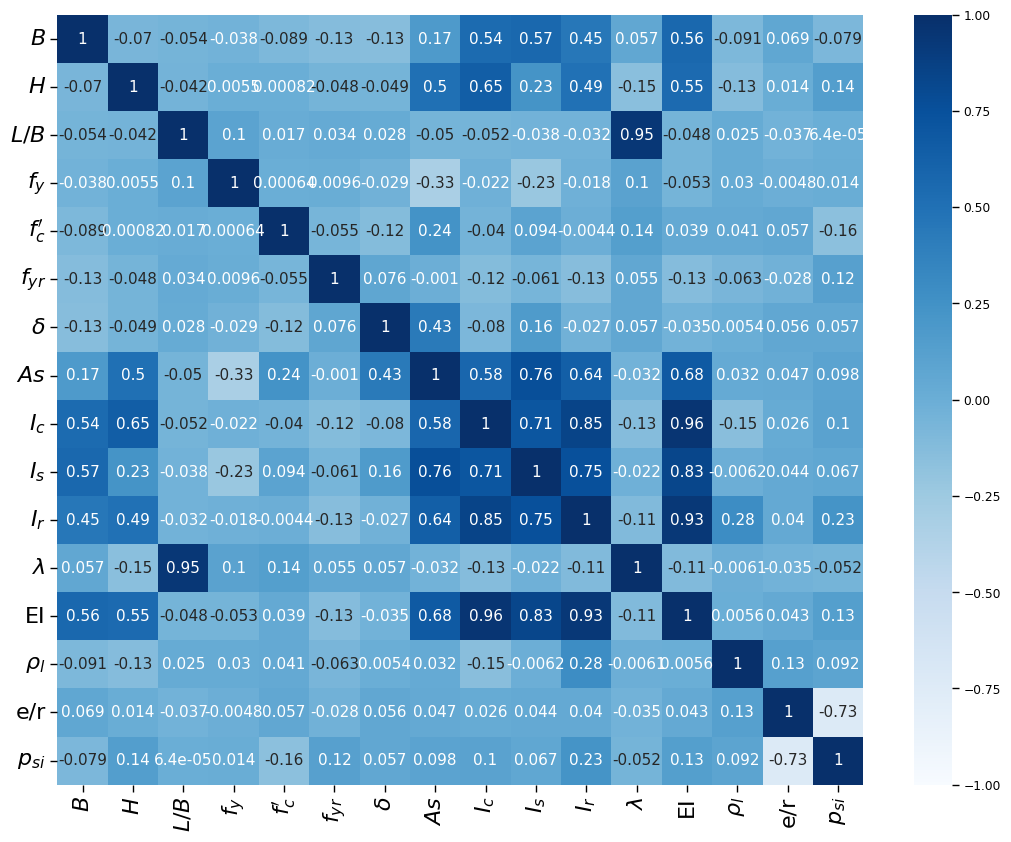

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
PC['As']=As; PC['Ic']=np.minimum((H**3. * B/12.0 - I_S_X - I_REBAR_X),(H * B**3./12.0 - I_S_Y - I_REBAR_Y));PC['Is']=np.minimum(I_S_X,I_S_Y); PC['I_REBAR_X']=np.minimum(I_REBAR_X,I_REBAR_Y)
PC['EI']=EI;
X1=PC[['B', 'H', 'Lam', 'fy', 'fc','frebar', 'delta','As','Ic','Is','I_REBAR_X','slender','EI','rho_l','e_B', 'P_PcS']]
column_labels = ['$B$', '$H$', '$L/B$', '$f_y$', '$f^\\prime_c$','$f_{yr}$','$\\delta$','$As$','$I_c$', '$I_s$','$I_r$','$\\lambda$','EI','$\\rho_l$','e/r','$p_{si}$']#\\tilde{p}

# Calculate Pearson's correlation coefficient between features (X1)
correlation_matrix = X1.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(13, 10),)
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", vmin=-1, vmax=1, center=0)

sns.set_context("paper", rc={"font.size": 11, "axes.titlesize": 12, "axes.labelsize": 12})
plt.xticks(fontsize=16);plt.yticks(fontsize=16)
plt.xticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.yticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.savefig("correlation_CFS_x.png")

# Show the colorbar as a side bar

# Display the plot
plt.show()


c:\Users\osama\anaconda3\lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


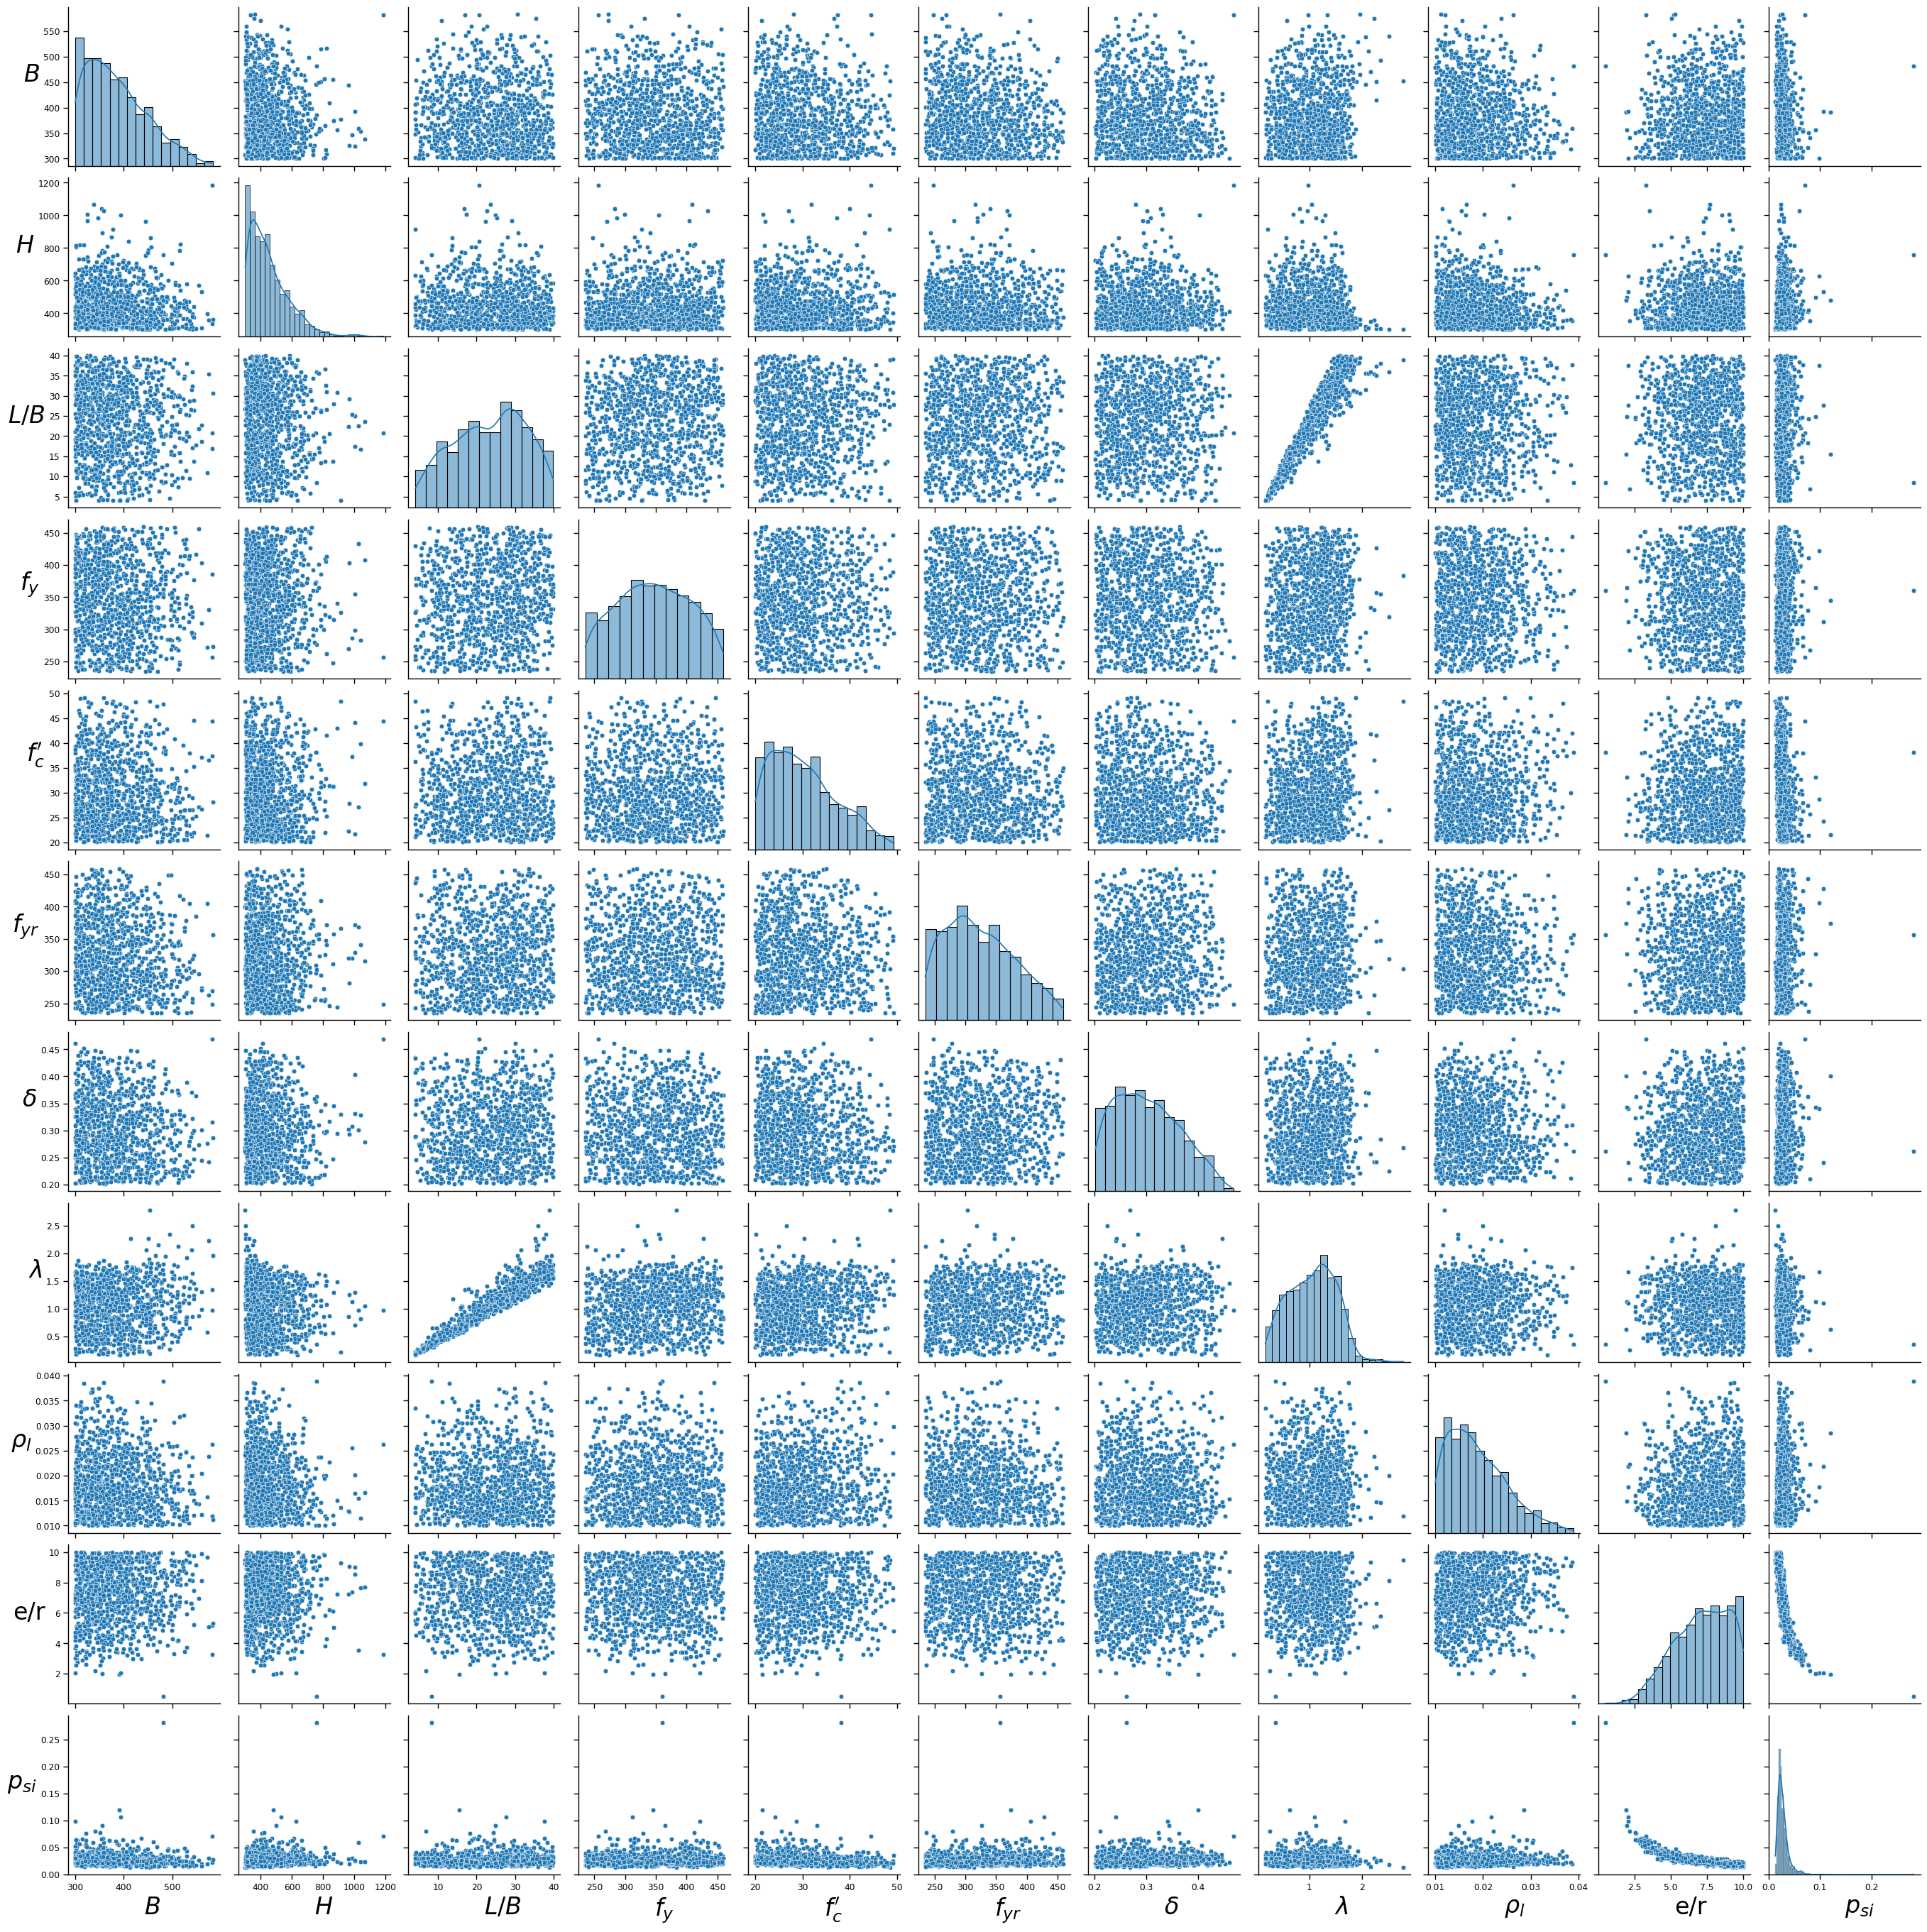

In [80]:
PC['XO']=1000.0*PC['P_PcS']
X1=PC[['B', 'H', 'Lam', 'fy', 'fc','frebar', 'delta','slender','rho_l','e_B', 'XO']]
x_vars = ['B', 'H', 'Lam', 'fy', 'fc','frebar', 'delta','slender','rho_l','e_B', 'XO']
aa=['$B$', '$H$', '$L/B$', '$f_y$', '$f^\\prime_c$','$f_{yr}$','$\\delta$','$\\lambda$','$\\rho_l$','e/r','$p_{si}$']
pairplot = sns.pairplot(X1, size=2.5, diag_kind='hist', diag_kws={'kde': True}, x_vars=x_vars)
i=0;j=0;font_size=24
for ax in pairplot.axes.flatten():
    ax.set_xlabel(aa[i],fontsize=font_size)
    ax.set_ylabel(aa[j],fontsize=font_size, rotation = 0)
    i=i+1
    if i==len(aa):
        i=0;j=j+1
    if j==len(aa):j=0
    ax.yaxis.get_label().set_horizontalalignment('right')
    ax.xaxis.get_label().set_horizontalalignment('left')
plt.savefig("correlation1_CFS_x.png")


In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel, WhiteKernel,RationalQuadratic,Matern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

PC  = pd.read_excel('path5.xlsx',sheet_name='Sheet1')


X=PC[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12']];y=PC['Y']/PC['paa']*1000.0

X,y = np.array(X.values),np.array(y.values);scaler = MinMaxScaler(feature_range=(-1, 1));scaler_out = MinMaxScaler(feature_range=(-1, 1))
X_normalized=scaler.fit_transform(X);y_normalized=scaler_out.fit_transform(y.reshape(-1,1))
X_tot=X_normalized;y_tot=y_normalized
X_train, X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.2, random_state=13)


In [84]:
X_train, X_test, aa_train, aa_test = train_test_split(X_tot, np.array(PC['paa']).reshape(-1,1), test_size=0.2, random_state=13)

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
import xgboost as xgb

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "gamma": trial.suggest_float("gamma",0.01, 100, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        #"num_leaves": trial.suggest_int("num_leaves", 10, 31),
        "boosting_type": trial.suggest_categorical("booster", ['gbtree', 'dart']),#, 'rf'
    }
    model = xgb.XGBRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-09-19 07:05:59,153] A new study created in memory with name: no-name-37f23340-86c6-440e-a655-484ca85a795c
[I 2024-09-19 07:07:27,958] Trial 6 finished with value: 0.23156516940325536 and parameters: {'n_estimators': 384, 'learning_rate': 0.004915690953518803, 'gamma': 0.31271080866099993, 'max_depth': 16, 'booster': 'gbtree'}. Best is trial 6 with value: 0.23156516940325536.
[I 2024-09-19 07:07:28,293] Trial 2 finished with value: 0.29087664349641296 and parameters: {'n_estimators': 73, 'learning_rate': 0.02251844034240745, 'gamma': 0.36249148515714014, 'max_depth': 48, 'booster': 'dart'}. Best is trial 6 with value: 0.23156516940325536.
[I 2024-09-19 07:07:30,261] Trial 5 finished with value: 0.03933617753501416 and parameters: {'n_estimators': 212, 'learning_rate': 0.024673840872705213, 'gamma': 8.561898731954717, 'max_depth': 23, 'booster': 'gbtree'}. Best is trial 5 with value: 0.03933617753501416.
[I 2024-09-19 07:07:35,674] Trial 0 finished with value: 0.03729419984129147

Best hyperparameters: {'n_estimators': 424, 'learning_rate': 0.03107484205891197, 'gamma': 0.0157862874389769, 'max_depth': 44, 'booster': 'gbtree'}
Best RMSE: 0.014590246259138889


In [88]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
aa=xgb.XGBRegressor(random_state=1000,n_estimators=424, max_depth=424, learning_rate=0.03107484205891197, booster='gbtree', gamma=0.0157862874389769)
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)*np.concatenate((np.array(aa_test ).reshape(-1, 1),np.array(aa_train).reshape(-1, 1)),axis=0)/1000.0
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))*np.concatenate((np.array(aa_test ).reshape(-1, 1),np.array(aa_train).reshape(-1, 1)),axis=0)/1000.0
data2=np.concatenate((data,data1),axis=1)


df = pd.DataFrame(data2)
#df.columns=['B', 'H', 'Lam', 'frebar', 'fc', 'delta','tw2', 'tf', 'hs2', 'bf2','A_rebar','e_B','P_exp','P_pred'];PC=df
df.columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','P_exp','P_pred'];PC=df
filename = 'XGB_CFS_x.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

0.021136584641868777
Data exported to XGB_CFS_x.xlsx


In [86]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
from lightgbm.sklearn import LGBMRegressor

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        #"gamma": trial.suggest_float("gamma",0.01, 100, log=True),
        "max_depth": trial.suggest_int("max_depth", 16, 50),
        "num_leaves": trial.suggest_int("num_leaves", 10, 31),
        "boosting_type": trial.suggest_categorical("boosting_type", ['gbdt', 'dart']),#, 'rf'
    }
    model = LGBMRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-09-19 09:04:57,300] A new study created in memory with name: no-name-f4da816a-d466-4a82-a63c-88e10a4ecd96
[I 2024-09-19 09:05:34,163] Trial 1 finished with value: 0.010197744405160063 and parameters: {'n_estimators': 1827, 'learning_rate': 0.08919666673092075, 'max_depth': 36, 'num_leaves': 18, 'boosting_type': 'dart'}. Best is trial 1 with value: 0.010197744405160063.
[I 2024-09-19 09:05:46,383] Trial 3 finished with value: 0.007924379772492465 and parameters: {'n_estimators': 235, 'learning_rate': 0.03061517822990068, 'max_depth': 18, 'num_leaves': 12, 'boosting_type': 'gbdt'}. Best is trial 3 with value: 0.007924379772492465.
[I 2024-09-19 09:05:51,398] Trial 0 finished with value: 0.010387557715778557 and parameters: {'n_estimators': 1258, 'learning_rate': 0.11415734199818545, 'max_depth': 44, 'num_leaves': 15, 'boosting_type': 'dart'}. Best is trial 3 with value: 0.007924379772492465.
[I 2024-09-19 09:05:53,916] Trial 15 finished with value: 0.015802178863251463 and parame

KeyboardInterrupt: 

[I 2024-09-19 09:06:45,235] Trial 28 finished with value: 0.007841750203845274 and parameters: {'n_estimators': 753, 'learning_rate': 0.01282402818375473, 'max_depth': 18, 'num_leaves': 26, 'boosting_type': 'gbdt'}. Best is trial 29 with value: 0.007604103507137928.


In [89]:
from lightgbm.sklearn import LGBMRegressor
aa=LGBMRegressor(n_estimators=1666,learning_rate=0.0646408285267663, max_depth=41, num_leaves=10, boosting_type='gbdt')
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)*np.concatenate((np.array(aa_test ).reshape(-1, 1),np.array(aa_train).reshape(-1, 1)),axis=0)/1000.0
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))*np.concatenate((np.array(aa_test ).reshape(-1, 1),np.array(aa_train).reshape(-1, 1)),axis=0)/1000.0
data2=np.concatenate((data,data1),axis=1)

df = pd.DataFrame(data2)
#df.columns=['B', 'H', 'Lam', 'frebar', 'fc', 'delta','tw2', 'tf', 'hs2', 'bf2','A_rebar','e_B','P_exp','P_pred'];PC=df
df.columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','P_exp','P_pred'];PC=df
filename = 'LGBM_CFS_x.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

c:\Users\osama\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 832, number of used features: 12
[LightGBM] [Info] Start training from score -0.935143
0.014313137925417253
Data exported to LGBM_CFS_x.xlsx


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
from sklearn.ensemble import RandomForestRegressor

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        #"learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 50),
        "max_features": trial.suggest_categorical("max_features", ['sqrt','log2']),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),        
    }
    model = RandomForestRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300,n_jobs=-1)#os.cpu_count()-1
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-09-19 07:17:37,794] A new study created in memory with name: no-name-7b11bc8b-45c6-4549-90b9-9143a9e15c38
[I 2024-09-19 07:17:48,556] Trial 0 finished with value: 0.021850223044506477 and parameters: {'n_estimators': 1530, 'max_depth': 4, 'min_samples_leaf': 28, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.021850223044506477.
[I 2024-09-19 07:17:49,297] Trial 1 finished with value: 0.0170673564743998 and parameters: {'n_estimators': 414, 'max_depth': 33, 'min_samples_leaf': 17, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.0170673564743998.
[I 2024-09-19 07:17:49,873] Trial 5 finished with value: 0.02116784439752134 and parameters: {'n_estimators': 207, 'max_depth': 40, 'min_samples_leaf': 32, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.0170673564743998.
[I 2024-09-19 07:17:50,138] Trial 2 finished with value: 0.01953892756864278 and parameters: {'n_estimators': 1091, 'max_depth': 45, 'min_

Best hyperparameters: {'n_estimators': 1529, 'max_depth': 17, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}
Best RMSE: 0.013495214457197185


In [90]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
aa=RandomForestRegressor(random_state=1000,n_estimators=1529, max_depth=17, min_samples_leaf=2, max_features='log2', bootstrap=True)
print(np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1)
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)*np.concatenate((np.array(aa_test ).reshape(-1, 1),np.array(aa_train).reshape(-1, 1)),axis=0)/1000.0
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))*np.concatenate((np.array(aa_test ).reshape(-1, 1),np.array(aa_train).reshape(-1, 1)),axis=0)/1000.0
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
#df.columns=['B', 'H', 'Lam', 'frebar', 'fc', 'delta','tw2', 'tf', 'hs2', 'bf2','A_rebar','e_B','P_exp','P_pred'];PC=df
df.columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','P_exp','P_pred'];PC=df
df.to_excel(filename, index=False)
print("Data exported to", filename)

0.013444035283246992


c:\Users\osama\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.02041729896114823
Data exported to RF_CFS_x.xlsx


In [15]:
import catboost as cb
import optuna
def objective(trial):
    params = {
        "iterations":trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-09-19 07:19:07,738] A new study created in memory with name: no-name-2d893979-e720-4438-bb01-f5f2df5e9ace
[I 2024-09-19 07:19:27,649] Trial 0 finished with value: 0.0048123770486120255 and parameters: {'iterations': 1802, 'learning_rate': 0.009723499725180664, 'depth': 3, 'subsample': 0.2907736388110447, 'colsample_bylevel': 0.6482818613350007, 'min_data_in_leaf': 7}. Best is trial 0 with value: 0.0048123770486120255.
[I 2024-09-19 07:19:30,261] Trial 2 finished with value: 0.026774746603817585 and parameters: {'iterations': 525, 'learning_rate': 0.0022525122542285244, 'depth': 2, 'subsample': 0.12418406038140624, 'colsample_bylevel': 0.3514885080079838, 'min_data_in_leaf': 76}. Best is trial 0 with value: 0.0048123770486120255.
[I 2024-09-19 07:19:42,643] Trial 3 finished with value: 0.004435626508280184 and parameters: {'iterations': 825, 'learning_rate': 0.02438028510202244, 'depth': 4, 'subsample': 0.7934929435933596, 'colsample_bylevel': 0.637960140410124, 'min_data_in_lea

In [91]:
import catboost as cb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
aa=cb.CatBoostRegressor(iterations=825,learning_rate=0.02438028510202244,depth=4,subsample=0.7934929435933596,colsample_bylevel=0.637960140410124,min_data_in_leaf= 9)
#value = np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1
aa.fit(X_train,y_train)
rmse = mean_absolute_percentage_error(y_test, aa.predict(X_test))
print(rmse)

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)*np.concatenate((np.array(aa_test ).reshape(-1, 1),np.array(aa_train).reshape(-1, 1)),axis=0)/1000.0
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))*np.concatenate((np.array(aa_test ).reshape(-1, 1),np.array(aa_train).reshape(-1, 1)),axis=0)/1000.0
data2=np.concatenate((data,data1),axis=1)


df = pd.DataFrame(data2)
#df.columns=['B', 'H', 'Lam', 'frebar', 'fc', 'delta','tw2', 'tf', 'hs2', 'bf2','A_rebar','e_B','P_exp','P_pred'];PC=df
df.columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','P_exp','P_pred'];PC=df

filename = 'CB_CFS_x.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

0:	learn: 0.0477770	total: 728us	remaining: 600ms
1:	learn: 0.0471525	total: 1.61ms	remaining: 661ms
2:	learn: 0.0466226	total: 2.29ms	remaining: 628ms
3:	learn: 0.0460660	total: 2.95ms	remaining: 605ms
4:	learn: 0.0453318	total: 3.52ms	remaining: 577ms
5:	learn: 0.0446454	total: 4.06ms	remaining: 554ms
6:	learn: 0.0445477	total: 4.7ms	remaining: 549ms
7:	learn: 0.0439595	total: 5.21ms	remaining: 532ms
8:	learn: 0.0433713	total: 5.98ms	remaining: 542ms
9:	learn: 0.0427884	total: 6.48ms	remaining: 528ms
10:	learn: 0.0421221	total: 7.17ms	remaining: 531ms
11:	learn: 0.0414262	total: 7.74ms	remaining: 524ms
12:	learn: 0.0409901	total: 8.48ms	remaining: 530ms
13:	learn: 0.0403445	total: 9.15ms	remaining: 530ms
14:	learn: 0.0397565	total: 9.78ms	remaining: 528ms
15:	learn: 0.0391598	total: 10.6ms	remaining: 534ms
16:	learn: 0.0385852	total: 11.1ms	remaining: 527ms
17:	learn: 0.0380777	total: 11.8ms	remaining: 527ms
18:	learn: 0.0375808	total: 12.5ms	remaining: 529ms
19:	learn: 0.0370294	tot

SVR

In [11]:
import pso
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import math

num_folds=5
def objective_function(params):
    C, epsilon, gamma = params
    mse_scores = []
    
    # Split the data into folds
    fold_size = len(X_train) // num_folds
    folds_X = np.array_split(X_train, num_folds)
    folds_y = np.array_split(y_train, num_folds)
    
    # Perform cross-validation
    for i in range(num_folds):
        # Create the SVR model
        model = SVR(C=math.exp(C), epsilon=math.exp(epsilon), gamma=math.exp(gamma))
        
        # Merge the data for training and testing
        X_test_fold,X_train_fold = folds_X[i], np.concatenate(folds_X[:i] + folds_X[i+1:])
        y_test_fold,y_train_fold = folds_y[i], np.concatenate(folds_y[:i] + folds_y[i+1:])

        # Train the model and predict
        model.fit(X_train_fold, y_train_fold.reshape(-1))
        y_pred_fold = model.predict(X_test_fold)
        
        # Calculate the mean squared error
        divide = scaler_out.inverse_transform(y_pred_fold.reshape(-1, 1))/scaler_out.inverse_transform(y_test_fold.reshape(-1, 1))
        mse_fold = np.std(divide)
        
        mse_scores.append(mse_fold)
    
    # Calculate the mean of the mse scores
    mse = np.mean(mse_scores)
    return mse
lower_bound = [-3., -100.,-10.]
upper_bound = [5., -10., 20.]


# Define Optimization Problem
problem = {'CostFunction': objective_function, 'nVar': 3, 'VarMin': lower_bound, 'VarMax': upper_bound}

# Running PSO
gbest, pop = pso.PSO(problem, MaxIter = 10, PopSize = 100, c1 = 1.0, c2 = 1.0, w = 0.1, wdamp = 0.1)
# Final Result
print('Global Best:')
print(gbest)


Iteration 0: Best Cost = 0.024621721396619826
Global Best:
{'position': array([  2.39182304, -26.92672716,  -3.65286534]), 'cost': 0.024621721396619826}


In [63]:
score = objective_function(gbest['position'])
print(gbest['cost'])
C, epsilon, gamma = gbest['position']#2.39182304, -26.92672716,  -3.65286534

model = SVR(C=math.exp(C), epsilon=math.exp(epsilon), gamma=math.exp(gamma))
model.fit(X_train, y_train.reshape(-1))
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = model.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)*np.concatenate((np.array(aa_test ).reshape(-1, 1),np.array(aa_train).reshape(-1, 1)),axis=0)/1000.0
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))*np.concatenate((np.array(aa_test ).reshape(-1, 1),np.array(aa_train).reshape(-1, 1)),axis=0)/1000.0
data2=np.concatenate((data,data1),axis=1)

df = pd.DataFrame(data2)
#df.columns=['B', 'H', 'Lam', 'frebar', 'fc', 'delta','tw2', 'tf', 'hs2', 'bf2','A_rebar','e_B','P_exp','P_pred'];PC=df
df.columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','P_exp','P_pred'];PC=df
filename = 'SVR_CFS_x.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)


0.024621721396619826
0.009621074165981808
Data exported to SVR_CFS_x.xlsx


save

Circular

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel, WhiteKernel,RationalQuadratic,Matern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
pi = math.pi
from sklearn.model_selection import cross_val_score

# Define the GPR model
gpr = GaussianProcessRegressor()
gpr.kernel = (
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    Matern(length_scale=1.0, length_scale_bounds=(1e-5, 1e5), nu=1.0) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    WhiteKernel(noise_level=0.1) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    RationalQuadratic(length_scale=1, alpha=1)
)

# Set up the parameter grid for alpha
alpha_values = [0.0001,0.0005,0.001,0.0013]  # Add more values if needed

# Perform cross-validation to find the best alpha
best_alpha = None
best_score = -np.inf
for alpha in alpha_values:
    gpr.alpha = alpha
    scores = cross_val_score(gpr, X_train, y_train.reshape(-1, 1), cv=5)  # Use your desired number of folds
    mean_score = np.mean(scores)
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha


In [28]:
print(best_alpha)

0.0001


In [38]:
# Fit the GPR model with the best alpha
gpr.alpha = best_alpha
gpr.fit(X_train, y_train.reshape(-1, 1))

# Make predictions using the trained model
y_pred, y_std = gpr.predict(X_normalized, return_std=True)
if y_tot.ndim>1 and y_tot.shape[1]==1:y_tot=np.squeeze(y_tot,axis=1)
y_tot11=y_tot;y_std11=y_std;y_pred11=y_pred


c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


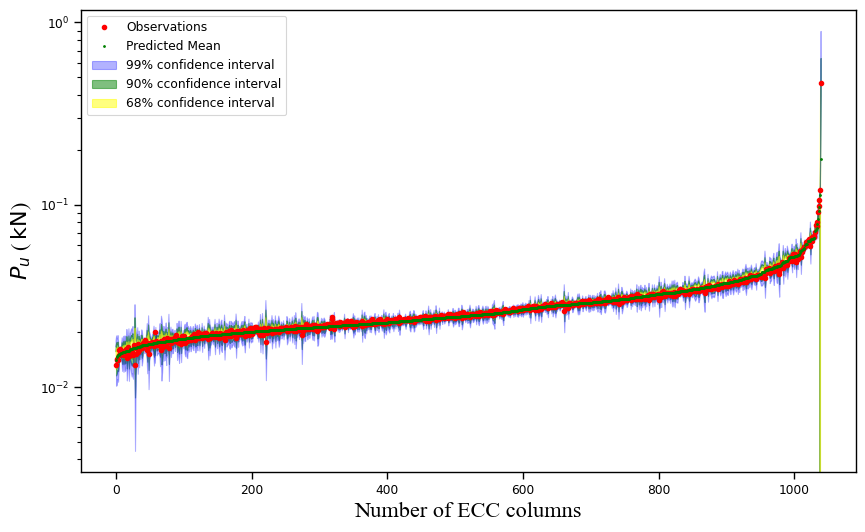

In [39]:
y_tot11=y_tot;X_tot11=X_tot;y_pred11=y_pred;y_std2=y_std
yr=y_std2.reshape(-1, 1)+y_pred.reshape(-1, 1)
data = scaler_out.inverse_transform( y_tot11.reshape(-1, 1))
data1= scaler_out.inverse_transform(y_pred11.reshape(-1, 1))
yr   = scaler_out.inverse_transform(yr.reshape(-1, 1))
y_std2=yr.reshape(-1, 1)-data.reshape(-1, 1)
X     =     scaler.inverse_transform(X_tot)



data2=np.concatenate((X,data.reshape(-1, 1),data1.reshape(-1, 1)),axis=1)
df = pd.DataFrame(data2)
df.columns = ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','P_exp','P_pred'];PC_ecc=df;PC_ecc['sd']=y_std2
y_tot11=np.array(PC_ecc['P_exp'].values);y_pred11=np.array(PC_ecc['P_pred'].values);y_std2=np.array(PC_ecc['sd'].values)

filename ='Gpr_Rect_ecc1_m12342.xlsx'
PC_ecc.to_excel(filename, index=False)


#arrange
vv = np.vstack((X_tot11.transpose(),y_std2,y_tot11,y_pred11)).transpose()
v1 = vv[np.argsort(vv[:, -1])]
#previous sheet excel is wrong as you didnot sort x_tot
X_tot11,y_std2,y_tot11,y_pred11=v1[:,:-3],v1[:,-3],v1[:,-2],v1[:,-1]
# Calculate the upper and lower confidence bounds
#0.674
#2.576 is 99% confidence 1.96 is 95%confidence interval #1.645 is 90% #2.576 for 99% #1.0 for 68%
lower_bound99 = y_pred11.flatten() - 2.576* y_std2.flatten();upper_bound99 = y_pred11.flatten() + 2.576* y_std2.flatten()#99% confidence
lower_bound90 = y_pred11.flatten() - 1.645* y_std2.flatten();upper_bound90 = y_pred11.flatten() + 1.645* y_std2.flatten()#1.645 is 90%
lower_bound68 = y_pred11.flatten() - 1.0  * y_std2.flatten();upper_bound68 = y_pred11.flatten() + 1.0  * y_std2.flatten()#1.0 for 68%
# Plot the data, true function, and confidence intervals
plt.figure(figsize=(10, 6))
sizy=np.arange(lower_bound68.shape[0])
plt.semilogy(sizy, y_tot11, 'ro', label='Observations', markersize=3);plt.semilogy(sizy, y_pred11, 'go', label='Predicted Mean', markersize=1)
# Fill between the confidence bounds
plt.fill_between(sizy, upper_bound90.flatten(), upper_bound99.flatten(), color='blue', alpha=0.3,label='99% confidence interval')
plt.fill_between(sizy, upper_bound68.flatten(), upper_bound90.flatten(), color='green', alpha=0.5,label='90% cconfidence interval')
plt.fill_between(sizy, lower_bound68.flatten(), upper_bound68.flatten(), color='yellow', alpha=0.5,label='68% confidence interval')
plt.fill_between(sizy, lower_bound90.flatten(), lower_bound68.flatten(), color='green', alpha=0.5)
plt.fill_between(sizy, lower_bound99.flatten(), lower_bound90.flatten(), color='blue', alpha=0.3)

plt.xlabel('Number of ECC columns',fontdict={'fontname': 'Times New Roman', 'fontsize': 16});plt.ylabel(r'$P_{u}$ ($ \, \mathrm{kN}$)',fontdict={'fontname': 'Times New Roman', 'fontsize': 16});
plt.legend()
plt.savefig("GPR_Predicted_Mean_Confidence_Intervals1.png", dpi=500)
plt.show()
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = gpr.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)*np.concatenate((np.array(aa_test ).reshape(-1, 1),np.array(aa_train).reshape(-1, 1)),axis=0)/1000.0
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))*np.concatenate((np.array(aa_test ).reshape(-1, 1),np.array(aa_train).reshape(-1, 1)),axis=0)/1000.0
data2=np.concatenate((data,data1),axis=1)


df = pd.DataFrame(data2)
df.columns = ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','P_exp','P_pred'];PC_ecc=df;PC_ecc['sd']=y_std2;
y_tot11=np.array(PC_ecc['P_exp'].values);y_pred11=np.array(PC_ecc['P_pred'].values);y_std2=np.array(PC_ecc['sd'].values)

filename ='GPR_CFS_x.xlsx'
PC_ecc.to_excel(filename, index=False)


# Proposed Design

In [92]:
import numpy as np
from scipy.optimize import fsolve
import scipy.io as sio
import pandas as pd

from math import pi
def get_m_from_n(axis, nn, pc, MD, H,B, fc, Ac, As, fy, Ar,fr,cover, bf,tw,hs,tf,zs, f_fc, xi,rho1):
    if axis ==1:
        n = nn;sign=1.0
        if nn>pc/2.0: n = pc/2.0-(nn-pc/2.0);sign=-1.0
        min_zr = 0.0
        hn = (-n*2.0 + 0.85*fc*Ac)/2.0/(0.85*fc*(B-tw) + 2*fy*tw )
        if abs(hn)<hs/2.0-tf:
            zsn = tw*hn**2.0
            a=0.0
        else:
            hn = (-n*2.0 + 0.85*fc*(H*B-hs*bf) - 2*fy*(As-hs*bf))/2.0/(0.85*fc*(B-tw) + 2*fy*tw )
            hn = (-n*2   + pc- 2.0*(As-hs*bf)*(fy-fc*0.85/2.0))/2.0/(0.85*fc*B + 2*bf*(fy-0.85*fc/2.0))
            if hn<hs/2:
                zsn=zs -bf*(hs/2-hn)*(hs/2+hn)
                a=1.0
            else:
                hn = (-n*2.0 + 0.85*fc*(H*B)-2.*fy*As - 2*fr*Ar)/2.0/(0.85*fc*B)
                hn1=hn
                t=0
                if hn>H/2.0-cover:
                    zsn =zs
                    min_zr=Ar*(H/2.0-cover)
                    a=2.0
                    t=1
                if t==0: hn = (-n*2.0 + 0.85*fc*(Ac+As)-2*fy*As)/2.0/(0.85*fc*B)
                hn2=hn
                if hn<H/2.0-cover and t ==0:
                    zsn =zs
                    t=1
                    a=3.0
                if t==0:
                    hn=H/2.0-cover
                    #print('f   ',hn2,hn,hn1)
                    zsn = zs
                    min_zr = Ar*(H/2.0-cover)*(hn2-hn)/(hn2-hn1)
                    a=4.0
                
        zcn = B*hn**2.0-zsn -min_zr
    else:
        #minor
        min_zr = 0.0
        hn = (0.85*fc*(Ac+As-2.*tf*bf)-2.*fy*(As-2.*tf*bf))/2.0/(4.*tf*fy+(H-2.*tf)*0.85*fc)
        if hn<tw/2.0: 
            zsn = 0.0
        else:
            if hn<bf/2.0:
                hn = (0.85*fc*(Ac+As-2.*tf*bf)-2.*fy*(As-2.*tf*bf))/2.0/(4.*tf*fy+(H-2.*tf)*0.85*fc)
                zsn = zs -2*tf*(bf/2+hn)*(bf/2-hn)
            else:
                if hn<B/2.0-cover:
                    hn = (0.85*fc*(Ac+As)-2*fy*As)/2.0/(0.85*fc*H)
                    zsn = zs
                else:
                    hn = (0.85*fc*(H*B)-2.0*fy*As-2.0*fr*Ar)/2.0/(0.85*fc*H)
                    min_zr = Ar*(B/2.0-cover)
                    zsn = zs
        zcn = H*hn**2.0-zsn- min_zr
    MMM = xi * (MD - zsn * fy - 0.5 * f_fc * fc * zcn - min_zr*fr+(H/2.0-sign*hn)**2.0*B/2.0*fc/10.0) #0.2 instead of 0.29
    MMM = xi * (MD - zsn * fy - 0.5 * f_fc * fc * zcn - min_zr*fr+(H/2.0-sign*hn)*(H/2.0-(H/2.0-sign*hn)/2.0)*B*fc/10.0) #0.31 instead of 0.29
    MMM = xi * (MD - zsn * fy - 0.5 * f_fc * fc * zcn - min_zr*fr+(H/2.0+sign*hn)**2.0*B/2.0*0.2*fc**0.75) #0.09867 instead of 0.29
    #MMM = xi * (MD - zsn * fy - 0.5 * f_fc * fc * zcn - min_zr*fr+(H/2.0-sign*hn)**2.0*B*fc/4.0*(1.0-rho1)) #0.0987 instead of 0.29
    #print(hn)
    return MMM 
def get_m_for_ecc_And_2ndorder_MN_diagramR(axis,m, method, ec, ee, Ncr, pc, pa,MD, Ar, fr,cover, H,B, fc, Ac, As, fy, bf,tw,hs,tf,zs, f_fc, xi,rho1):
    i = 0
    eess=0
    while i < 50:
        #print('Ncr', Ncr)
        if method == 'DSM':
            n = 1 / (ec / m + 1 / Ncr)
        else:
            n = m / ee
        if n<0.0:
            n=0.
        if n > pa:
            n = pa * 0.99
        mm = get_m_from_n(axis, n,pc, MD, H,B, fc, Ac, As, fy, Ar,fr,cover, bf,tw,hs,tf,zs, f_fc, xi,rho1)
        r = m - mm
        #print('r',r)
        #print('m',m)
        #print('mm',mm)
        if abs(r) / max(abs(mm),10.0) < 0.001:
            #print('break');
            break
        m = mm
        i=i+1
        if i == 49:    eess = 1
    #print('true ecc', mm/n)
    if eess == 1:
        eess = 0
        i=0
        while i < 1000:
            i=i+1 
            n = i / 1000 * pa
            if method == 'DSM':
                m = n * ec / (1 - n / Ncr)
            else:
                m = n * ee
            
            mm = get_m_from_n(axis, n, pc, MD, H,B, fc, Ac, As, fy, Ar,fr,cover, bf,tw,hs,tf,zs, f_fc, xi,rho1)
            if m > mm:
                break
        if i == 1000:  eess = 1
    #print(m/n)        
    return m, n, eess

def EC4RA(X, ntest):
    B = X[0]; H = X[1]; lam = X[2]; frebar = X[3]; fc = X[4]; fy = X[5]
    d_steel = X[6]; ro_rebar = X[7]; tf_tw_2 = X[8]; cH = X[9]; cB = X[10]
    axis = 1; et = (np.exp(X[11])-0.9)*H;    eb = et
    #axis =  X[11]; et =  X[12]; eb =  X[12]
    
    Astr = 50; S_space = 1000 * 50 * 2 / min(B, H); fstr = 250.0;  A_rebar_4 = ro_rebar * B * H / 4.0; cover = 30
    L = lam * B;    hs2 = (H - 2.0 * cH) / 2.0;     bf2 = (B - 2.0 * cB) / 2.0
    
    A_steel_4 = (4.*A_rebar_4 * frebar + 0.85 * B * H * 0.97 * fc) * d_steel / fy / 4.0; tw2 = A_steel_4 / ((bf2 - 4.0) * tf_tw_2 + hs2); tf = (A_steel_4 - hs2 * tw2) / (bf2 - tw2)
    
    #frebar1=fy;fy=frebar;frebar=frebar1
    f_fc = 0.85;  Es = 210000;  Ec = 22000 * ((fc + 8.) / 10.)**0.3
    Ar = ro_rebar * B * H;  As = ((hs2 * 2.) * (bf2 * 2.) - (hs2 * 2. - 2. * tf) * (bf2 * 2. - 2. * tw2));  Ac = H * B - Ar - As
    
    I_S_X = ((hs2 * 2.)**3. * (bf2 * 2.) - (hs2 * 2. - 2. * tf)**3 * (bf2 * 2. - 2. * tw2)) / 12.0
    I_REBAR_X = Ar * (H - 2.0 * cover)**2. / 4.0
    EI1 = (I_S_X + I_REBAR_X) * Es + (H**3. * B/12.0 - I_S_X - I_REBAR_X) * Ec * 0.6
    
    I_S_Y = ((bf2 * 2.)**3. * tf * 2.0 + (hs2 * 2. - 2. * tf) * (2. * tw2)**3) / 12.0
    I_REBAR_Y = Ar * (B - 2.0 * cover)**2. / 4.0
    EI2 = (I_S_Y + I_REBAR_Y) * Es + (H * B**3./12.0 - I_S_Y - I_REBAR_Y) * Ec * 0.6
    EI = min(EI1, EI2)
    #print(EI1/EI2)
    pc = Ac * fc * f_fc
    pa = pc + As * fy + Ar * frebar
    
    Ncr = (np.pi**2. * EI) / (L * L)
    slender = (pa / Ncr)**0.5; rho1=(A_steel_4+A_rebar_4)*4.0/(B*H)
    #print(slender)
    #phi = 0.5 * (1 + 0.21 * (slender - 0.2) + slender**2);chi = min(1, 1 / (phi + (phi**2 - slender**2)**0.5));EC4 = chi * pa ;print(chi);ratioECP1 = ntest[0] / EC4*1000

    ee = max(abs(et), abs(eb))
    # EC4
    xi = 0.9
    xi=1.0
    if axis == 1:
        beta = max(0.44, 0.66 + 0.44 * np.sign(et * eb) * min(abs(et), abs(eb)) / ee)
        EI1 = ( (I_S_X + I_REBAR_X) * Es + (H**3. * B/12.0 - I_S_X - I_REBAR_X) * Ec * 0.9)##################################################################
        Ncr = (np.pi**2 * EI1) / (L * L)
        ec = max(L / 2000., ee * beta)
        
        zs = ((hs2 * 2.)**2. * (bf2 * 2.) - (hs2 * 2. - 2. * tf)**2 * (bf2 * 2. - 2. * tw2)) / 4.0
        zr = Ar * (H - 2.0 * cover) / 2.0
        zc = H**2. * B/4.0 - zs-zr;     MD = (zs * fy + zr * frebar + 0.5 * f_fc * zc * fc)

        m,n,conver = get_m_for_ecc_And_2ndorder_MN_diagramR(axis,10, 'DSM', ec, ee, Ncr, pc, pa,MD, Ar, frebar,cover, H,B, fc, Ac, As, fy, 2.0*bf2,2.0*tw2,2.0*hs2,tf,zs, f_fc, xi,rho1)
        #EC4 = min(EC4, n / 1000)
        EC4 = n/1000
    else:
        beta = max(0.44, 0.66 + 0.44 * np.sign(et * eb) * min(abs(et), abs(eb)) / ee)
        EI2 = 0.9*( (I_S_Y + I_REBAR_Y) * Es + (H * B**3./12.0 - I_S_Y - I_REBAR_Y) * Ec * 0.5)
        Ncr = (np.pi**2 * EI2) / (L * L)
        ec = max(L / 3000., ee * beta)
        #print(ec)
        zs = ((bf2 * 2.)**2. * tf * 2.0 + (hs2 * 2. - 2. * tf) * (2. * tw2)**2.) / 4.0
        zr = Ar * (B - 2.0 * cover) / 2.0
        zc = H * B**2./4.0 - zs-zr;     MD = (zs * fy + zr * frebar + 0.5 * f_fc * zc * fc)
        m,n,conver = get_m_for_ecc_And_2ndorder_MN_diagramR(axis,10, 'DSM', ec, ee, Ncr, pc, pa,MD, Ar, frebar,cover, H,B, fc, Ac, As, fy, 2.0*bf2,2.0*tw2,2.0*hs2,tf,zs, f_fc, xi)
        #EC4 = min(EC4, n / 1000)
        EC4 = n/1000
        #print(m/n)

    ratioEC4 = ntest / EC4
    #print(et/H, slender,ratioEC4[0])
    #if range[0] < ratioEC4 < range[1]:    inrange = 1
    return ratioEC4[0], conver, m/n, pa,EC4

mat_data = sio.loadmat('X_Y_data1_m.mat');X = mat_data['X_all'];Y = mat_data['Y_all']

# Calculate the ratio for each specimen
results = np.array([EC4RA(X[i, :], Y[i]) for i in range(X.shape[0])])

ratios = results[:, 0]; paa=results[:,3];EC4=results[:,4]
df = pd.DataFrame(np.hstack([X, Y.reshape(-1, 1),  ratios.reshape(-1, 1),  paa.reshape(-1, 1),  EC4.reshape(-1, 1)]), 
                  columns=[f'X{i+1}' for i in range(X.shape[1])] + ['P_exp', 'Ratio Ntest/NEC4', 'paa','P_pred'])

# Export the DataFrame to an Excel sheet
output_file = 'prop_CFS_x1.xlsx'
df.to_excel(output_file, index=False)
print("EC4_CFS: mean and CoV", np.mean(ratios),np.std(ratios)/np.mean(ratios))

EC4_CFS: mean and CoV 1.0697091453534293 0.02371107679415128


# EC4

In [93]:
import numpy as np
from scipy.optimize import fsolve
import scipy.io as sio
import pandas as pd

from math import pi
def get_m_from_n(axis, nn, pc, MD, H,B, fc, Ac, As, fy, Ar,fr,cover, bf,tw,hs,tf,zs, f_fc, xi,rho1):
    if axis ==1:
        n = nn;sign=1.0
        if nn>pc/2.0: n = pc/2.0-(nn-pc/2.0);sign=-1.0
        min_zr = 0.0
        hn = (-n*2.0 + 0.85*fc*Ac)/2.0/(0.85*fc*(B-tw) + 2*fy*tw )
        if abs(hn)<hs/2.0-tf:
            zsn = tw*hn**2.0
            a=0.0
        else:
            hn = (-n*2.0 + 0.85*fc*(H*B-hs*bf) - 2*fy*(As-hs*bf))/2.0/(0.85*fc*(B-tw) + 2*fy*tw )
            hn = (-n*2   + pc- 2.0*(As-hs*bf)*(fy-fc*0.85/2.0))/2.0/(0.85*fc*B + 2*bf*(fy-0.85*fc/2.0))
            if hn<hs/2:
                zsn=zs -bf*(hs/2-hn)*(hs/2+hn)
                a=1.0
            else:
                hn = (-n*2.0 + 0.85*fc*(H*B)-2.*fy*As - 2*fr*Ar)/2.0/(0.85*fc*B)
                hn1=hn
                t=0
                if hn>H/2.0-cover:
                    zsn =zs
                    min_zr=Ar*(H/2.0-cover)
                    a=2.0
                    t=1
                if t==0: hn = (-n*2.0 + 0.85*fc*(Ac+As)-2*fy*As)/2.0/(0.85*fc*B)
                hn2=hn
                if hn<H/2.0-cover and t ==0:
                    zsn =zs
                    t=1
                    a=3.0
                if t==0:
                    hn=H/2.0-cover
                    #print('f   ',hn2,hn,hn1)
                    zsn = zs
                    min_zr = Ar*(H/2.0-cover)*(hn2-hn)/(hn2-hn1)
                    a=4.0
                
        zcn = B*hn**2.0-zsn -min_zr
    else:
        #minor
        min_zr = 0.0
        hn = (0.85*fc*(Ac+As-2.*tf*bf)-2.*fy*(As-2.*tf*bf))/2.0/(4.*tf*fy+(H-2.*tf)*0.85*fc)
        if hn<tw/2.0: 
            zsn = 0.0
        else:
            if hn<bf/2.0:
                hn = (0.85*fc*(Ac+As-2.*tf*bf)-2.*fy*(As-2.*tf*bf))/2.0/(4.*tf*fy+(H-2.*tf)*0.85*fc)
                zsn = zs -2*tf*(bf/2+hn)*(bf/2-hn)
            else:
                if hn<B/2.0-cover:
                    hn = (0.85*fc*(Ac+As)-2*fy*As)/2.0/(0.85*fc*H)
                    zsn = zs
                else:
                    hn = (0.85*fc*(H*B)-2.0*fy*As-2.0*fr*Ar)/2.0/(0.85*fc*H)
                    min_zr = Ar*(B/2.0-cover)
                    zsn = zs
        zcn = H*hn**2.0-zsn- min_zr
    MMM = xi * (MD - zsn * fy - 0.5 * f_fc * fc * zcn - min_zr*fr+(H/2.0-sign*hn)**2.0*B/2.0*fc/10.0) #0.2 instead of 0.29
    MMM = xi * (MD - zsn * fy - 0.5 * f_fc * fc * zcn - min_zr*fr+(H/2.0-sign*hn)*(H/2.0-(H/2.0-sign*hn)/2.0)*B*fc/10.0) #0.31 instead of 0.29
    MMM = xi * (MD - zsn * fy - 0.5 * f_fc * fc * zcn - min_zr*fr+(H/2.0+sign*hn)**2.0*B/2.0*0.2*fc**0.75) #0.09867 instead of 0.29
    MMM = xi * (MD - zsn * fy - 0.5 * f_fc * fc * zcn - min_zr*fr) #0.09867 instead of 0.29
    #MMM = xi * (MD - zsn * fy - 0.5 * f_fc * fc * zcn - min_zr*fr+(H/2.0-sign*hn)**2.0*B*fc/4.0*(1.0-rho1)) #0.0987 instead of 0.29
    #print(hn)
    return MMM 
def get_m_for_ecc_And_2ndorder_MN_diagramR(axis,m, method, ec, ee, Ncr, pc, pa,MD, Ar, fr,cover, H,B, fc, Ac, As, fy, bf,tw,hs,tf,zs, f_fc, xi,rho1):
    i = 0
    eess=0
    while i < 50:
        #print('Ncr', Ncr)
        if method == 'DSM':
            n = 1 / (ec / m + 1 / Ncr)
        else:
            n = m / ee
        if n<0.0:
            n=0.
        if n > pa:
            n = pa * 0.99
        mm = get_m_from_n(axis, n,pc, MD, H,B, fc, Ac, As, fy, Ar,fr,cover, bf,tw,hs,tf,zs, f_fc, xi,rho1)
        r = m - mm
        #print('r',r)
        #print('m',m)
        #print('mm',mm)
        if abs(r) / max(abs(mm),10.0) < 0.001:
            #print('break');
            break
        m = mm
        i=i+1
        if i == 49:    eess = 1
    #print('true ecc', mm/n)
    if eess == 1:
        eess = 0
        i=0
        while i < 1000:
            i=i+1 
            n = i / 1000 * pa
            if method == 'DSM':
                m = n * ec / (1 - n / Ncr)
            else:
                m = n * ee
            
            mm = get_m_from_n(axis, n, pc, MD, H,B, fc, Ac, As, fy, Ar,fr,cover, bf,tw,hs,tf,zs, f_fc, xi,rho1)
            if m > mm:
                break
        if i == 1000:  eess = 1
    #print(m/n)        
    return m, n, eess

def EC4RA(X, ntest):
    B = X[0]; H = X[1]; lam = X[2]; frebar = X[3]; fc = X[4]; fy = X[5]
    d_steel = X[6]; ro_rebar = X[7]; tf_tw_2 = X[8]; cH = X[9]; cB = X[10]
    axis = 1; et = (np.exp(X[11])-0.9)*H;    eb = et
    #axis =  X[11]; et =  X[12]; eb =  X[12]
    
    Astr = 50; S_space = 1000 * 50 * 2 / min(B, H); fstr = 250.0;  A_rebar_4 = ro_rebar * B * H / 4.0; cover = 30
    L = lam * B;    hs2 = (H - 2.0 * cH) / 2.0;     bf2 = (B - 2.0 * cB) / 2.0
    
    A_steel_4 = (4.*A_rebar_4 * frebar + 0.85 * B * H * 0.97 * fc) * d_steel / fy / 4.0; tw2 = A_steel_4 / ((bf2 - 4.0) * tf_tw_2 + hs2); tf = (A_steel_4 - hs2 * tw2) / (bf2 - tw2)
    
    #frebar1=fy;fy=frebar;frebar=frebar1
    f_fc = 0.85;  Es = 210000;  Ec = 22000 * ((fc + 8.) / 10.)**0.3
    Ar = ro_rebar * B * H;  As = ((hs2 * 2.) * (bf2 * 2.) - (hs2 * 2. - 2. * tf) * (bf2 * 2. - 2. * tw2));  Ac = H * B - Ar - As
    
    I_S_X = ((hs2 * 2.)**3. * (bf2 * 2.) - (hs2 * 2. - 2. * tf)**3 * (bf2 * 2. - 2. * tw2)) / 12.0
    I_REBAR_X = Ar * (H - 2.0 * cover)**2. / 4.0
    EI1 = (I_S_X + I_REBAR_X) * Es + (H**3. * B/12.0 - I_S_X - I_REBAR_X) * Ec * 0.6
    
    I_S_Y = ((bf2 * 2.)**3. * tf * 2.0 + (hs2 * 2. - 2. * tf) * (2. * tw2)**3) / 12.0
    I_REBAR_Y = Ar * (B - 2.0 * cover)**2. / 4.0
    EI2 = (I_S_Y + I_REBAR_Y) * Es + (H * B**3./12.0 - I_S_Y - I_REBAR_Y) * Ec * 0.6
    EI = min(EI1, EI2)
    #print(EI1/EI2)
    pc = Ac * fc * f_fc
    pa = pc + As * fy + Ar * frebar
    
    Ncr = (np.pi**2. * EI) / (L * L)
    slender = (pa / Ncr)**0.5; rho1=(A_steel_4+A_rebar_4)*4.0/(B*H)
    #print(slender)
    #phi = 0.5 * (1 + 0.21 * (slender - 0.2) + slender**2);chi = min(1, 1 / (phi + (phi**2 - slender**2)**0.5));EC4 = chi * pa ;print(chi);ratioECP1 = ntest[0] / EC4*1000

    ##########################################if axis == 1:
    ok_EC4 = 1;ok_AISC = 1;ok_ECP = 1;compact = 1;short = 1; MN = 0; inrange = 0#   if range[0] < ratioEC4 < range[1]:   inrange = 1
    ee = max(abs(et), abs(eb))
    # EC4
    xi = 0.9
    xi = 1.0
    if axis == 1:
        beta = max(0.44, 0.66 + 0.44 * np.sign(et * eb) * min(abs(et), abs(eb)) / ee)
        EI1 = 0.9*( (I_S_X + I_REBAR_X) * Es + (H**3. * B/12.0 - I_S_X - I_REBAR_X) * Ec * 0.5)##################################################################
        Ncr = (np.pi**2 * EI1) / (L * L)
        ec = max(L / 2000., ee * beta)
        
        zs = ((hs2 * 2.)**2. * (bf2 * 2.) - (hs2 * 2. - 2. * tf)**2 * (bf2 * 2. - 2. * tw2)) / 4.0
        zr = Ar * (H - 2.0 * cover) / 2.0
        zc = H**2. * B/4.0 - zs-zr;     MD = (zs * fy + zr * frebar + 0.5 * f_fc * zc * fc)

        m,n,conver = get_m_for_ecc_And_2ndorder_MN_diagramR(axis,10, 'DSM', ec, ee, Ncr, pc, pa,MD, Ar, frebar,cover, H,B, fc, Ac, As, fy, 2.0*bf2,2.0*tw2,2.0*hs2,tf,zs, f_fc, xi,rho1)
        #EC4 = min(EC4, n / 1000)
        EC4 = n/1000
    else:
        beta = max(0.44, 0.66 + 0.44 * np.sign(et * eb) * min(abs(et), abs(eb)) / ee)
        EI2 = 0.9*( (I_S_Y + I_REBAR_Y) * Es + (H * B**3./12.0 - I_S_Y - I_REBAR_Y) * Ec * 0.5)
        Ncr = (np.pi**2 * EI2) / (L * L)
        ec = max(L / 3000., ee * beta)

        zs = ((bf2 * 2.)**2. * tf * 2.0 + (hs2 * 2. - 2. * tf) * (2. * tw2)**2.) / 4.0
        zr = Ar * (B - 2.0 * cover) / 2.0
        zc = H * B**2./4.0 - zs-zr;     MD = (zs * fy + zr * frebar + 0.5 * f_fc * zc * fc)
        m,n,conver = get_m_for_ecc_And_2ndorder_MN_diagramR(axis,10, 'DSM', ec, ee, Ncr, pc, pa,MD, Ar, frebar,cover, H,B, fc, Ac, As, fy, 2.0*bf2,2.0*tw2,2.0*hs2,tf,zs, f_fc, xi)
        #EC4 = min(EC4, n / 1000)
        EC4 = n/1000
        #print(m/n)

    ratioEC4 = ntest / EC4
    #print(et/H, slender,ratioEC4[0])
    #if range[0] < ratioEC4 < range[1]:    inrange = 1
    return ratioEC4[0], conver, m/n, pa,EC4

mat_data = sio.loadmat('X_Y_data1_m.mat');X = mat_data['X_all'];Y = mat_data['Y_all']

# Calculate the ratio for each specimen
results = np.array([EC4RA(X[i, :], Y[i]) for i in range(X.shape[0])])

ratios = results[:, 0]; paa=results[:,3];EC4=results[:,4]
df = pd.DataFrame(np.hstack([X, Y.reshape(-1, 1),  ratios.reshape(-1, 1),  paa.reshape(-1, 1),  EC4.reshape(-1, 1)]), 
                  columns=[f'X{i+1}' for i in range(X.shape[1])] + ['P_exp', 'Ratio Ntest/NEC4', 'paa','P_pred'])

# Export the DataFrame to an Excel sheet
output_file = 'EC4_CFS_x1.xlsx'
df.to_excel(output_file, index=False)
print("EC4_CFS: mean and CoV", np.mean(ratios),np.std(ratios)/np.mean(ratios))

EC4_CFS: mean and CoV 1.1986731379184905 0.038997650631077935


# AISC

In [94]:
import numpy as np
from scipy.optimize import fsolve
import scipy.io as sio
import pandas as pd

from math import pi
def get_m_from_n(axis, nn, pc, MD, H,B, fc, Ac, As, fy, Ar,fr,cover, bf,tw,hs,tf,zs, f_fc, xi,rho1):
    if axis ==1:
        n = nn;sign=1.0
        if nn>pc/2.0: n = pc/2.0-(nn-pc/2.0);sign=-1.0
        min_zr = 0.0
        hn = (-n*2.0 + 0.85*fc*Ac)/2.0/(0.85*fc*(B-tw) + 2*fy*tw )
        if abs(hn)<hs/2.0-tf:
            zsn = tw*hn**2.0
            a=0.0
        else:
            hn = (-n*2.0 + 0.85*fc*(H*B-hs*bf) - 2*fy*(As-hs*bf))/2.0/(0.85*fc*(B-tw) + 2*fy*tw )
            hn = (-n*2   + pc- 2.0*(As-hs*bf)*(fy-fc*0.85/2.0))/2.0/(0.85*fc*B + 2*bf*(fy-0.85*fc/2.0))
            if hn<hs/2:
                zsn=zs -bf*(hs/2-hn)*(hs/2+hn)
                a=1.0
            else:
                hn = (-n*2.0 + 0.85*fc*(H*B)-2.*fy*As - 2*fr*Ar)/2.0/(0.85*fc*B)
                hn1=hn
                t=0
                if hn>H/2.0-cover:
                    zsn =zs
                    min_zr=Ar*(H/2.0-cover)
                    a=2.0
                    t=1
                if t==0: hn = (-n*2.0 + 0.85*fc*(Ac+As)-2*fy*As)/2.0/(0.85*fc*B)
                hn2=hn
                if hn<H/2.0-cover and t ==0:
                    zsn =zs
                    t=1
                    a=3.0
                if t==0:
                    hn=H/2.0-cover
                    #print('f   ',hn2,hn,hn1)
                    zsn = zs
                    min_zr = Ar*(H/2.0-cover)*(hn2-hn)/(hn2-hn1)
                    a=4.0
                
        zcn = B*hn**2.0-zsn -min_zr
    else:
        #minor
        min_zr = 0.0
        hn = (0.85*fc*(Ac+As-2.*tf*bf)-2.*fy*(As-2.*tf*bf))/2.0/(4.*tf*fy+(H-2.*tf)*0.85*fc)
        if hn<tw/2.0: 
            zsn = 0.0
        else:
            if hn<bf/2.0:
                hn = (0.85*fc*(Ac+As-2.*tf*bf)-2.*fy*(As-2.*tf*bf))/2.0/(4.*tf*fy+(H-2.*tf)*0.85*fc)
                zsn = zs -2*tf*(bf/2+hn)*(bf/2-hn)
            else:
                if hn<B/2.0-cover:
                    hn = (0.85*fc*(Ac+As)-2*fy*As)/2.0/(0.85*fc*H)
                    zsn = zs
                else:
                    hn = (0.85*fc*(H*B)-2.0*fy*As-2.0*fr*Ar)/2.0/(0.85*fc*H)
                    min_zr = Ar*(B/2.0-cover)
                    zsn = zs
        zcn = H*hn**2.0-zsn- min_zr
    MMM = xi * (MD - zsn * fy - 0.5 * f_fc * fc * zcn - min_zr*fr+(H/2.0-sign*hn)**2.0*B/2.0*fc/10.0) #0.2 instead of 0.29
    MMM = xi * (MD - zsn * fy - 0.5 * f_fc * fc * zcn - min_zr*fr+(H/2.0-sign*hn)*(H/2.0-(H/2.0-sign*hn)/2.0)*B*fc/10.0) #0.31 instead of 0.29
    MMM = xi * (MD - zsn * fy - 0.5 * f_fc * fc * zcn - min_zr*fr+(H/2.0+sign*hn)**2.0*B*fc**0.75 /  10.0    ) #0.09867 instead of 0.29
    MMM = xi * (MD - zsn * fy - 0.5 * f_fc * fc * zcn - min_zr*fr) #0.09867 instead of 0.29
    #MMM = xi * (MD - zsn * fy - 0.5 * f_fc * fc * zcn - min_zr*fr+(H/2.0-sign*hn)**2.0*B*fc/4.0*(1.0-rho1)) #0.0987 instead of 0.29
    #print(hn)
    return MMM 
def get_m_for_ecc_And_2ndorder_MN_diagramR(axis,m, method, ec, ee, Ncr, pc, pa,MD, Ar, fr,cover, H,B, fc, Ac, As, fy, bf,tw,hs,tf,zs, f_fc, xi,rho1):
    i = 0
    eess=0
    while i < 50:
        #print('Ncr', Ncr)
        if method == 'DSM':
            n = 1 / (ec / m + 1 / Ncr)
        else:
            n = m / ee
        if n<0.0:
            n=0.
        if n > pa:
            n = pa * 0.99
        mm = get_m_from_n(axis, n,pc, MD, H,B, fc, Ac, As, fy, Ar,fr,cover, bf,tw,hs,tf,zs, f_fc, xi,rho1)
        r = m - mm
        #print('r',r)
        #print('m',m)
        #print('mm',mm)
        if abs(r) / max(abs(mm),10.0) < 0.001:
            #print('break');
            break
        m = mm
        i=i+1
        if i == 49:    eess = 1
    #print('true ecc', mm/n)
    if eess == 1:
        eess = 0
        i=0
        while i < 1000:
            i=i+1 
            n = i / 1000 * pa
            if method == 'DSM':
                m = n * ec / (1 - n / Ncr)
            else:
                m = n * ee
            
            mm = get_m_from_n(axis, n, pc, MD, H,B, fc, Ac, As, fy, Ar,fr,cover, bf,tw,hs,tf,zs, f_fc, xi,rho1)
            if m > mm:
                break
        if i == 1000:  eess = 1
    #print(m/n)        
    return m, n, eess

def EC4RA(X, ntest):
    B = X[0]; H = X[1]; lam = X[2]; frebar = X[3]; fc = X[4]; fy = X[5]
    d_steel = X[6]; ro_rebar = X[7]; tf_tw_2 = X[8]; cH = X[9]; cB = X[10]
    axis = 1; et = (np.exp(X[11])-0.9)*H;    eb = et
    #axis =  X[11]; et =  X[12]; eb =  X[12]
    
    Astr = 50; S_space = 1000 * 50 * 2 / min(B, H); fstr = 250.0;  A_rebar_4 = ro_rebar * B * H / 4.0; cover = 30
    L = lam * B;    hs2 = (H - 2.0 * cH) / 2.0;     bf2 = (B - 2.0 * cB) / 2.0
    
    A_steel_4 = (4.*A_rebar_4 * frebar + 0.85 * B * H * 0.97 * fc) * d_steel / fy / 4.0; tw2 = A_steel_4 / ((bf2 - 4.0) * tf_tw_2 + hs2); tf = (A_steel_4 - hs2 * tw2) / (bf2 - tw2)
    
    #frebar1=fy;fy=frebar;frebar=frebar1
    f_fc = 0.85;  Es = 210000;  Ec = 22000 * ((fc + 8.) / 10.)**0.3
    Ar = ro_rebar * B * H;  As = ((hs2 * 2.) * (bf2 * 2.) - (hs2 * 2. - 2. * tf) * (bf2 * 2. - 2. * tw2));  Ac = H * B - Ar - As
    
    I_S_X = ((hs2 * 2.)**3. * (bf2 * 2.) - (hs2 * 2. - 2. * tf)**3 * (bf2 * 2. - 2. * tw2)) / 12.0
    I_REBAR_X = Ar * (H - 2.0 * cover)**2. / 4.0
    EI1 = (I_S_X + I_REBAR_X) * Es + (H**3. * B/12.0 - I_S_X - I_REBAR_X) * Ec * 0.6
    
    I_S_Y = ((bf2 * 2.)**3. * tf * 2.0 + (hs2 * 2. - 2. * tf) * (2. * tw2)**3) / 12.0
    I_REBAR_Y = Ar * (B - 2.0 * cover)**2. / 4.0
    EI2 = (I_S_Y + I_REBAR_Y) * Es + (H * B**3./12.0 - I_S_Y - I_REBAR_Y) * Ec * 0.6
    EI = min(EI1, EI2)
    #print(EI1/EI2)
    pc = Ac * fc * f_fc
    pa = pc + As * fy + Ar * frebar
    
    Ncr = (np.pi**2. * EI) / (L * L)
    slender = (pa / Ncr)**0.5; rho1=(A_steel_4+A_rebar_4)*4.0/(B*H)
    #print(slender)
    #phi = 0.5 * (1 + 0.21 * (slender - 0.2) + slender**2);chi = min(1, 1 / (phi + (phi**2 - slender**2)**0.5));EC4 = chi * pa ;print(chi);ratioECP1 = ntest[0] / EC4*1000

    ##########################################if axis == 1:
    ok_EC4 = 1;ok_AISC = 1;ok_ECP = 1;compact = 1;short = 1; MN = 0; inrange = 0#   if range[0] < ratioEC4 < range[1]:   inrange = 1
    ee = max(abs(et), abs(eb))
    c1=min(0.1+2*(As)/(As+Ac),0.3)
    # EC4
    xi = 1.0
    if axis == 1:
        beta = max(0.4, 0.6 + 0.4 * np.sign(et * eb) * min(abs(et), abs(eb)) / ee)
        EI1 = 0.8*( (I_S_X + 0.5*I_REBAR_X) * Es + (H**3. * B/12.0 - I_S_X - I_REBAR_X) * Ec * c1)##################################################################
        Ncr = (np.pi**2 * EI1) / (L * L)
        ec = max(L / 2000., ee * beta)
        
        zs = ((hs2 * 2.)**2. * (bf2 * 2.) - (hs2 * 2. - 2. * tf)**2 * (bf2 * 2. - 2. * tw2)) / 4.0
        zr = Ar * (H - 2.0 * cover) / 2.0
        zc = H**2. * B/4.0 - zs-zr;     MD = (zs * fy + zr * frebar + 0.5 * f_fc * zc * fc)

        m,n,conver = get_m_for_ecc_And_2ndorder_MN_diagramR(axis,10, 'DSM', ec, ee, Ncr, pc, pa,MD, Ar, frebar,cover, H,B, fc, Ac, As, fy, 2.0*bf2,2.0*tw2,2.0*hs2,tf,zs, f_fc, xi,rho1)
        #EC4 = min(EC4, n / 1000)
        EC4 = n/1000
    else:
        beta = max(0.4, 0.6 + 0.4 * np.sign(et * eb) * min(abs(et), abs(eb)) / ee)
        EI2 = 0.8*( (I_S_Y + 0.5*I_REBAR_Y) * Es + (H * B**3./12.0 - I_S_Y - I_REBAR_Y) * Ec * c1)
        Ncr = (np.pi**2 * EI2) / (L * L)
        ec = max(L / 3000., ee * beta)
        #print(ec)
        zs = ((bf2 * 2.)**2. * tf * 2.0 + (hs2 * 2. - 2. * tf) * (2. * tw2)**2.) / 4.0
        zr = Ar * (B - 2.0 * cover) / 2.0
        zc = H * B**2./4.0 - zs-zr;     MD = (zs * fy + zr * frebar + 0.5 * f_fc * zc * fc)
        m,n,conver = get_m_for_ecc_And_2ndorder_MN_diagramR(axis,10, 'DSM', ec, ee, Ncr, pc, pa,MD, Ar, frebar,cover, H,B, fc, Ac, As, fy, 2.0*bf2,2.0*tw2,2.0*hs2,tf,zs, f_fc, xi)
        #EC4 = min(EC4, n / 1000)
        EC4 = n/1000
        #print(m/n)

    ratioEC4 = ntest / EC4
    #print(et/H, slender,ratioEC4[0])
    #if range[0] < ratioEC4 < range[1]:    inrange = 1
    return ratioEC4[0], conver, m/n, pa,EC4

mat_data = sio.loadmat('X_Y_data1_m.mat');X = mat_data['X_all'];Y = mat_data['Y_all']

# Calculate the ratio for each specimen
results = np.array([EC4RA(X[i, :], Y[i]) for i in range(X.shape[0])])

ratios = results[:, 0]; paa=results[:,3];EC4=results[:,4]
df = pd.DataFrame(np.hstack([X, Y.reshape(-1, 1),  ratios.reshape(-1, 1),  paa.reshape(-1, 1),  EC4.reshape(-1, 1)]), 
                  columns=[f'X{i+1}' for i in range(X.shape[1])] + ['P_exp', 'Ratio Ntest/NEC4', 'paa','P_pred'])

# Export the DataFrame to an Excel sheet
output_file = 'AISC_CFS_x1.xlsx'
df.to_excel(output_file, index=False)
print("AISC_CFS: mean and CoV", np.mean(ratios),np.std(ratios)/np.mean(ratios))

AISC_CFS: mean and CoV 1.1220999660065094 0.06104774915778767
